In [15]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import dash
from dash import dcc, html, Input, Output

In [16]:
news_df = pd.read_excel("data/news_excerpts_parsed.xlsx")
news_df.head()

,Link,Text
0,https://edition.cnn.com/2023/09/29/business/st...,Starbucks violated federal labor law when it i...
1,https://www.channelnewsasia.com/singapore/su-w...,The first suspect to plead guilty in Singapore...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,Meta has been fined a record-breaking €1.2 bil...
3,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
4,https://edition.cnn.com/2024/03/05/politics/li...,The Department of Education imposed a record $...


In [17]:
news_df.shape

(1509, 2)

In [18]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [19]:
# Encode the corpus (news_df["Text"]) into dense embeddings
corpus_embeddings = model.encode(news_df["Text"].tolist(), convert_to_tensor=True)

In [20]:
# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Extract spaCy's default stop words list
spacy_stop_words = nlp.Defaults.stop_words

def preprocess_text_with_spacy(text):
    """
    Tokenize, remove stop words using spaCy, and perform lemmatization.
    Args:
        text: A single string.
    Returns:
        List of processed tokens.
    """
    doc = nlp(text)
    processed_tokens = [
        token.lemma_.lower() for token in doc if token.is_alpha and token.text.lower() not in spacy_stop_words
    ]
    return processed_tokens

def extract_keywords_from_text(texts, top_n=5):
    """
    Extract keywords from a list of texts using TF-IDF with spaCy stop word removal and lemmatization.
    Args:
        texts: List of strings representing the cluster.
        top_n: Number of top keywords to extract.
    Returns:
        List of top keywords.
    """
    # Define the custom TF-IDF Vectorizer with a spaCy-based tokenizer
    vectorizer = TfidfVectorizer(
        tokenizer=preprocess_text_with_spacy,
        stop_words=None,  # Custom stop words are handled in the tokenizer
        max_features=1000
    )
    X = vectorizer.fit_transform(texts)
    feature_array = vectorizer.get_feature_names_out()
    tfidf_sorting = X.sum(axis=0).A1.argsort()[::-1]  # Sort features by importance

    top_keywords = [feature_array[i] for i in tfidf_sorting[:top_n]]
    return top_keywords

## K-MEANS

In [21]:
def kmeans_clustering(embeddings, n_clusters):
    """
    Perform K-Means Clustering on embeddings.
    Args:
        embeddings: Array of embeddings (e.g., dense vectors for texts).
        n_clusters: Number of clusters to form.
    Returns:
        List of cluster labels for each data point.
    """
    # Convert embeddings to NumPy if necessary
    if hasattr(embeddings, "cpu"):  # Check if embeddings are tensors
        embeddings = embeddings.cpu().numpy()

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(embeddings)
    return kmeans.inertia_  # Return WCSS for this cluster count


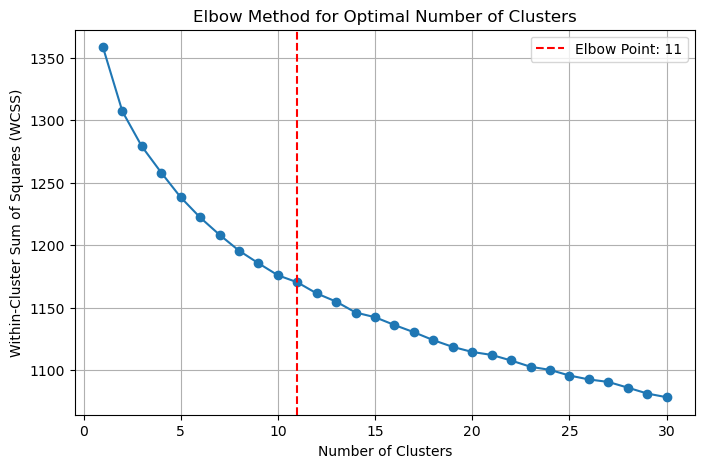

Suggested Elbow Point (Optimal Number of Clusters): 11


In [22]:
def plot_elbow_method_with_annotation(embeddings, max_clusters=10):
    """
    Plot the Elbow Method with an annotation for the optimal number of clusters.
    Args:
        embeddings: Array of embeddings (e.g., dense vectors for texts).
        max_clusters: Maximum number of clusters to test.
    """
    # Convert embeddings to NumPy if necessary
    if hasattr(embeddings, "cpu"):  # Check if embeddings are tensors
        embeddings = embeddings.cpu().numpy()

    # Compute WCSS for each number of clusters
    wcss = []
    for k in range(1, max_clusters + 1):
        inertia = kmeans_clustering(embeddings, n_clusters=k)
        wcss.append(inertia)

    # Calculate second derivative to find the elbow point
    x = np.arange(1, max_clusters + 1)
    wcss_diff = np.diff(wcss)
    wcss_diff2 = np.diff(wcss_diff)
    elbow_point = np.argmin(wcss_diff2) + 2  # Adding 2 because np.diff reduces length by 1

    # Plot WCSS against the number of clusters
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.axvline(x=elbow_point, color='r', linestyle='--', label=f"Elbow Point: {elbow_point}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.title("Elbow Method for Optimal Number of Clusters")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Suggested Elbow Point (Optimal Number of Clusters): {elbow_point}")

# Usage
plot_elbow_method_with_annotation(corpus_embeddings, max_clusters=30)

In [ ]:
from sklearn.metrics import silhouette_score

def evaluate_silhouette_scores(embeddings, max_clusters=10):
    if hasattr(embeddings, "cpu"):
        embeddings = embeddings.cpu().numpy()

    scores = []
    for k in range(2, max_clusters + 1):  # Silhouette score is undefined for k=1
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        scores.append(score)

    # Plot the scores
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score for Optimal Number of Clusters")
    plt.grid()
    plt.show()
    
    return scores

scores = evaluate_silhouette_scores(corpus_embeddings, max_clusters=30)

In [ ]:
def kmeans_clustering(embeddings, n_clusters):
    """
    Perform K-Means Clustering on embeddings.
    Args:
        embeddings: Array of embeddings (e.g., dense vectors for texts).
        n_clusters: Number of clusters to form.
    Returns:
        List of cluster labels for each data point.
    """
    # Convert embeddings to NumPy if necessary
    if hasattr(embeddings, "cpu"):  # Check if embeddings are tensors
        embeddings = embeddings.cpu().numpy()

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    return cluster_labels

In [ ]:
# Specify the number of clusters
n_clusters = 11  # Adjust as needed
cluster_labels = kmeans_clustering(corpus_embeddings, n_clusters=n_clusters)

# Organize and print results
clusters = {i: [] for i in range(n_clusters)}
for idx, label in enumerate(cluster_labels):
    clusters[label].append(idx)

# Print clusters
for i, cluster in clusters.items():
    # Gather all texts for the current cluster
    cluster_texts = news_df["Text"].iloc[cluster].tolist()
    
    # Extract keywords from the aggregated texts
    keywords = extract_keywords_from_text(cluster_texts, top_n=5)
    
    # Print cluster details
    print(f"\nCluster {i + 1}, #{len(cluster)} Elements")
    print("Keywords:", ", ".join(keywords))
    
    # Print all texts in the cluster
    for text in cluster_texts:
        print("\t", text)
        print("----------------------------------------")

In [ ]:
# Prepare data for Dash
cluster_data = []
for i, cluster in clusters.items():
    cluster_texts = news_df["Text"].iloc[cluster].tolist()
    keywords = extract_keywords_from_text(cluster_texts, top_n=5)
    cluster_data.append({
        "Cluster": f"Cluster {i + 1}",
        "Keywords": ", ".join(keywords),
        "Texts": cluster_texts
    })
cluster_df = pd.DataFrame(cluster_data)

# Initialize Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Cluster Visualization"),
    dcc.Dropdown(
        id="cluster-dropdown",
        options=[{"label": row["Cluster"] + ": " + row["Keywords"] + " (" + len(cluster_texts) + ")", "value": row["Cluster"]} for _, row in cluster_df.iterrows()],
        placeholder="Select a cluster"
    ),
    html.Div(id="keywords-output", style={"marginTop": "20px", "fontSize": "18px"}),
    html.Div(id="texts-output", style={"marginTop": "20px", "fontSize": "16px", "lineHeight": "1.5"}),
])

@app.callback(
    [Output("keywords-output", "children"),
     Output("texts-output", "children")],
    [Input("cluster-dropdown", "value")]
)
def display_cluster_details(selected_cluster):
    if not selected_cluster:
        return "Select a cluster to see details.", ""

    cluster_row = cluster_df[cluster_df["Cluster"] == selected_cluster].iloc[0]
    keywords = f"Keywords: {cluster_row['Keywords']}"
    texts = html.Ul([html.Li(text) for text in cluster_row["Texts"]])
    return keywords, texts

if __name__ == '__main__':
    app.run_server(debug=True)

## Hierarchical Clustering

In [7]:
from sklearn.cluster import AgglomerativeClustering

def hierarchical_clustering(embeddings, n_clusters):
    """
    Perform Hierarchical Clustering on embeddings.
    Args:
        embeddings: Array of embeddings (e.g., dense vectors for texts).
        n_clusters: Number of clusters to form.
    Returns:
        List of cluster labels for each data point.
    """
    # Convert embeddings to NumPy if necessary
    if hasattr(embeddings, "cpu"):  # Check if embeddings are tensors
        embeddings = embeddings.cpu().numpy()

    # Perform Agglomerative Clustering
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = clustering_model.fit_predict(embeddings)

    return cluster_labels



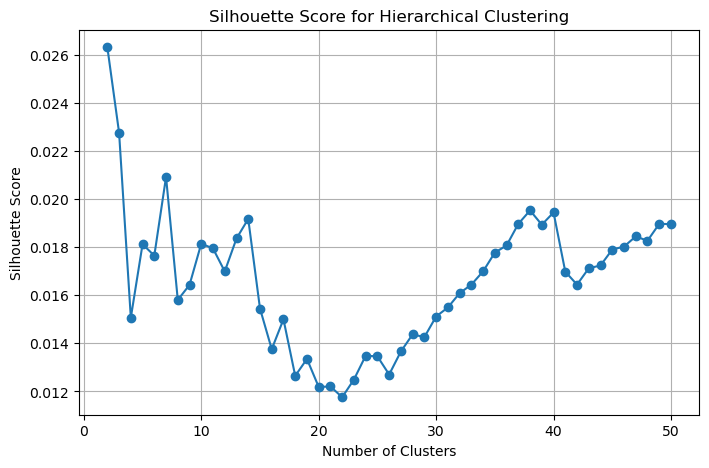

Optimal number of clusters based on Silhouette Score: 2


In [8]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_clusters_hierarchical(embeddings, max_clusters=10):
    """
    Find the optimal number of clusters for Hierarchical Clustering using the Silhouette Score.
    Args:
        embeddings: Array of embeddings (e.g., dense vectors for texts).
        max_clusters: Maximum number of clusters to test.
    Returns:
        Optimal number of clusters based on the highest Silhouette Score.
    """
    if hasattr(embeddings, "cpu"):  # Check if embeddings are tensors
        embeddings = embeddings.cpu().numpy()

    silhouette_scores = []

    # Test different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
        cluster_labels = clustering.fit_predict(embeddings)
        score = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(score)

    # Find the optimal number of clusters
    optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2

    # Plot the Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score for Hierarchical Clustering")
    plt.grid()
    plt.show()

    print(f"Optimal number of clusters based on Silhouette Score: {optimal_clusters}")
    return optimal_clusters

# Usage
optimal_n_clusters = find_optimal_clusters_hierarchical(corpus_embeddings, max_clusters=50)

In [9]:
# Specify the number of clusters
n_clusters = 38  # Adjust as needed
cluster_labels = hierarchical_clustering(corpus_embeddings, n_clusters=n_clusters)

# Organize and print results
clusters = {i: [] for i in range(n_clusters)}
for idx, label in enumerate(cluster_labels):
    clusters[label].append(idx)

# Print clusters
for i, cluster in clusters.items():
    # Gather all texts for the current cluster
    cluster_texts = news_df["Text"].iloc[cluster].tolist()
    
    # Extract keywords from the aggregated texts
    keywords = extract_keywords_from_text(cluster_texts, top_n=5)
    
    # Print cluster details
    print(f"\nCluster {i + 1}, #{len(cluster)} Elements")
    print("Keywords:", ", ".join(keywords))
    
    # Print all texts in the cluster
    for text in cluster_texts:
        print("\t", text)
        print("----------------------------------------")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Cluster 1, #33 Elements
Keywords: ai, nvidia, say, chip, company
	 Nvidia identified Huawei as a top competitor in several categories, including artificial intelligence chips, for the first time in a filing with the Securities and Exchange commission late on Wednesday (Feb 21).

The Santa Clara, California-based company said that China's Huawei competes in supplying chips designed for artificial intelligence such as graphics processing units (GPUs), central processing units (CPUs) and networking chips.

The company also identified Huawei as a cloud service company designing its own hardware and software to improve AI computing.

Nvidia declined to comment on Thursday.

Huawei developed the Ascend series of chips as a rival to Nvidia's line of AI chips. The Chinese company's main product, the 910B chip, is its main rival to Nvidia's A100 chip, which launched roughly three years ago.
----------------------------------------
	 Elon Musk said on Monday (Mar 11) his artificial intelligence

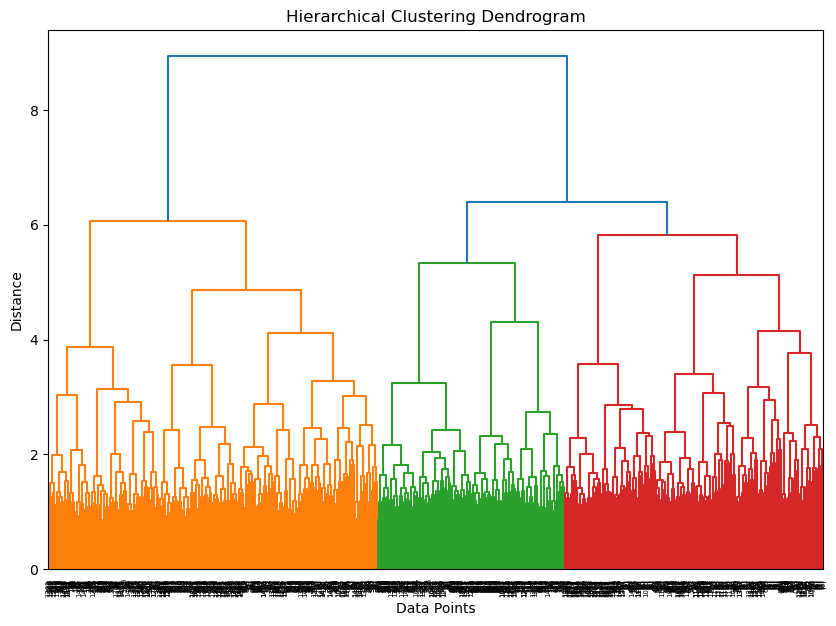

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def plot_dendrogram(embeddings, method='ward'):
    """
    Plot a dendrogram for hierarchical clustering.
    Args:
        embeddings: Array of embeddings (e.g., dense vectors for texts).
        method: Linkage method ('ward', 'complete', 'average', 'single').
    """
    # Convert embeddings to NumPy if necessary
    if hasattr(embeddings, "cpu"):  # Check if embeddings are tensors
        embeddings = embeddings.cpu().numpy()

    # Perform hierarchical clustering
    linked = linkage(embeddings, method=method)

    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linked, truncate_mode='level', p=10)  # Truncate for clarity
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    plt.show()

# Plot the dendrogram
plot_dendrogram(corpus_embeddings, method='ward')

In [11]:
# Prepare data for Dash
cluster_data = []
for i, cluster in clusters.items():
    cluster_texts = news_df["Text"].iloc[cluster].tolist()
    keywords = extract_keywords_from_text(cluster_texts, top_n=5)
    cluster_data.append({
        "Cluster": f"Cluster {i + 1}",
        "Keywords": ", ".join(keywords),
        "Texts": cluster_texts
    })
cluster_df = pd.DataFrame(cluster_data)

# Initialize Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Cluster Visualization"),
    dcc.Dropdown(
        id="cluster-dropdown",
        options=[{"label": row["Cluster"] + ": " + row["Keywords"] + " (" + str(len(row["Texts"])) + ")", "value": row["Cluster"]} for _, row in cluster_df.iterrows()],
        placeholder="Select a cluster"
    ),
    html.Div(id="keywords-output", style={"marginTop": "20px", "fontSize": "18px"}),
    html.Div(id="texts-output", style={"marginTop": "20px", "fontSize": "16px", "lineHeight": "1.5"}),
])

@app.callback(
    [Output("keywords-output", "children"),
     Output("texts-output", "children")],
    [Input("cluster-dropdown", "value")]
)
def display_cluster_details(selected_cluster):
    if not selected_cluster:
        return "Select a cluster to see details.", ""

    cluster_row = cluster_df[cluster_df["Cluster"] == selected_cluster].iloc[0]
    keywords = f"Keywords: {cluster_row['Keywords']}"
    texts = html.Ul([html.Li(text) for text in cluster_row["Texts"]])
    return keywords, texts

if __name__ == '__main__':
    app.run_server(debug=True)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
